In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import random

L2_WEIGHT_DECAY = 1e-4

In [2]:
PATH = '/data'
L_PATH = os.path.join(PATH, 'experts_anotation')
I_PATH = os.path.join(PATH, 'images')

print(L_PATH)
print(I_PATH)

/data/experts_anotation
/data/images


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
import os

def anot_to_img(expert, it):
    expert = str(expert)
    it = "{0:0=3d}".format(it)
    contours = []
    with open(os.path.join(L_PATH,'anotExpert'+expert+'_'+it+'.txt')) as f:
        line = f.readline()
        while line:
            x = re.findall("\d+\.\d+", line)
            contours.append([int(float(x[0])), int(float(x[1]))])
            line = f.readline()

    contours = np.array(contours)
    img = cv2.imread(os.path.join(I_PATH,'image_'+it+'.jpg'), cv2.IMREAD_GRAYSCALE)
    mask = np.zeros(img.shape, np.uint8)
    img = img[:,100:500]

    cv2.fillPoly(mask, pts =[contours], color=255)
    mask = mask[:,100:500]

    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask, (256,256), interpolation = cv2.INTER_AREA)
    return img, mask

def show_mask(expert, it):
    img, mask = anot_to_img(expert, it)
    output = img.copy()
    alpha = 0.3
    cv2.addWeighted(mask, alpha, output, 1 - alpha, 0, output)

    plt.imshow(output)

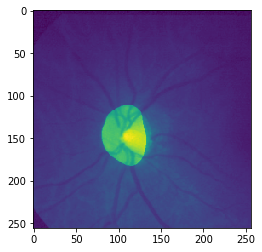

In [14]:
show_mask(2,19)

In [15]:
img, mask = anot_to_img(2,19)

(256, 256)


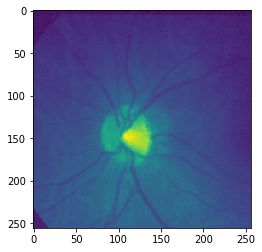

In [16]:
plt.imshow(img)
print(img.shape)


(256, 256)


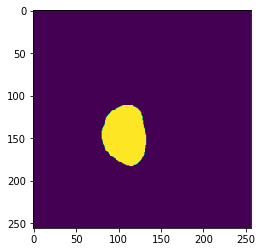

In [17]:
plt.imshow(mask)
print(mask.shape)

In [18]:
import random

def image_generator(files, batch_size = 32):
    while True: 
        #extract a random batch 
        batch = random.sample(files, batch_size)    

        #variables for collecting batches of inputs and outputs 
        batch_x = []
        batch_y = []

        for exp, it in batch:
            #get the masks. Note that masks are png files
            img, mask = anot_to_img(exp, it)

            if random.random() > 0.5:
                img = np.flip(img, axis=0)
                mask = np.flip(mask, axis=0)

            if random.random() > 0.5:
                img = np.flip(img, axis=1)
                mask = np.flip(mask, axis=1)

            batch_y.append(mask)
            batch_x.append(img)

        #preprocess a batch of images and masks 
        batch_x = np.array(batch_x)/255.
        batch_y = np.array(batch_y)/255.

        # opencv grayscale is (h,w) and we need (h,w,1)
        batch_x = np.expand_dims(batch_x,3)
        batch_y = np.expand_dims(batch_y,3)

        yield (batch_x, batch_y)      

In [29]:
def to_files(exp_range, it_range):
    files = []
    for it in it_range:
        for exp in exp_range:
            files.append((exp, it))
    return files

In [30]:
train_batch_size = 1
test_batch_size = 1

train_files = to_files(range(1,3), range(1,101))
test_files  = to_files(range(1,3), range(101,111))

train_generator = image_generator(train_files, batch_size = train_batch_size)
test_generator  = image_generator(test_files, batch_size = test_batch_size)

In [31]:
x, y = next(train_generator)

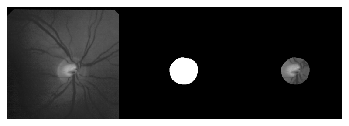

In [32]:
plt.axis('off')
img = x[0].squeeze()
img = np.stack((img,)*3, axis=-1)
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [33]:
def unet(sz = (256, 256, 1)):
    x = Input(sz)
    inputs = x

    #down sampling 
    f = 8
    layers = []

    for i in range(0, 2):
        x = Conv2D(f, 3, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
        x = Conv2D(f, 3, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
        layers.append(x)
        x = MaxPooling2D() (x)
        f = f*2
    ff2 = 64 

    #bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
    x = Conv2D(f, 3, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 

    #upsampling 
    for i in range(0, 1):
        ff2 = ff2//2
        f = f // 2 
        x = Conv2D(f, 3, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
        x = Conv2D(f, 3, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1 


    #classification 
    x = Conv2D(f, 3, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
    x = Conv2D(f, 3, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)
    outputs = Conv2D(1, 1, activation='sigmoid', use_bias=False, kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)) (x)

    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [34]:
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 8)  72          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 8)  576         conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_12[0][0]                  
____________________________________________________________________________________________

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam(lr=0.00001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_iou = tf.keras.metrics.MeanIoU(num_classes=2, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_iou = tf.keras.metrics.MeanIoU(num_classes=2, name='test_iou')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_iou(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_iou(labels, predictions)

In [37]:
from mlflow.tracking import MlflowClient

mlflow_client = MlflowClient()

EPOCHS = 5
TRAIN_STEPS = 20
TEST_STEPTS = 2
for epoch in range(EPOCHS):
    for i in range(TRAIN_STEPS):
        images, labels = next(train_generator)
        train_step(images, labels)
    for i in range(TEST_STEPTS):
        test_images, test_labels = next(test_generator)
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_iou.result()*100,
                        test_loss.result(),
                        test_iou.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_iou.reset_states()

Epoch 1, Loss: 0.693264365196228, Accuracy: 47.691497802734375, Test Loss: 0.6931912899017334, Test Accuracy: 47.87940979003906
Epoch 2, Loss: 0.6931544542312622, Accuracy: 47.8045654296875, Test Loss: 0.6930897235870361, Test Accuracy: 47.93853759765625
Epoch 3, Loss: 0.693020761013031, Accuracy: 47.920494079589844, Test Loss: 0.6928666234016418, Test Accuracy: 47.80158996582031
Epoch 4, Loss: 0.6928757429122925, Accuracy: 47.866172790527344, Test Loss: 0.692792534828186, Test Accuracy: 47.96409606933594
Epoch 5, Loss: 0.6926528215408325, Accuracy: 47.83039093017578, Test Loss: 0.6924912929534912, Test Accuracy: 47.89390563964844


In [40]:
!jupyter nbconvert --to script DRIONS_Segmentation.ipynb

[NbConvertApp] Converting notebook DRIONS_Segmentation.ipynb to script
[NbConvertApp] Writing 7941 bytes to DRIONS_Segmentation.py
